In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = False
load_gsea = False
run_umap = False

In [2]:
# Parameters
id_ = "Maynard_Bivona_2020_NSCLC"


# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 20592 × 55556
    obs: 'age', 'sex', 'well', 'plate', 'cell_id', 'sample', 'patient', 'race', 'smoking_status', 'condition', 'driver_gene', 'driver_mutation', 'secondary_mutation', 'Notes', 'stage_at_diagnosis', 'pathlogy_review', 'biopsy_date', 'sort_date', 'biopsy_type', 'tissue', 'origin', 'biopsy_time_status', 'early_treatment_status', 'best_response_status', 'biopsy_timing', 'analysis', 'treatment_history', 'treatment_history_detail', 'line_of_therapy', 'treatment_type', 'treatment', 'percent_PFS_ref_values', 'percent.PFS.reference.values', 'infections', 'early_bx_day', 'treatment_start_date', 'pfs_over_under', 'pfs_day', 'pfs_month', 'date_of_death', 'stageIII.IV_ca_dx_date', 'ca_dx_OS', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr',

### Types from infercnv dir

In [5]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,SRR10794350,Myeloid
1,SRR10785808,Myeloid
2,SRR10783827,Blood vessels
3,SRR10786816,Myeloid
4,SRR10779280,Myeloid
...,...,...
20587,SRR10794623,Myeloid
20588,SRR10781244,Airway epithelium
20589,SRR10798243,Myeloid
20590,SRR10796357,Lymphoid


In [6]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['age', 'sex', 'well', 'plate', 'cell_id', 'sample', 'patient', 'race',
       'smoking_status', 'condition', 'driver_gene', 'driver_mutation',
       'secondary_mutation', 'Notes', 'stage_at_diagnosis', 'pathlogy_review',
       'biopsy_date', 'sort_date', 'biopsy_type', 'tissue', 'origin',
       'biopsy_time_status', 'early_treatment_status', 'best_response_status',
       'biopsy_timing', 'analysis', 'treatment_history',
       'treatment_history_detail', 'line_of_therapy', 'treatment_type',
       'treatment', 'percent_PFS_ref_values', 'percent.PFS.reference.values',
       'infections', 'early_bx_day', 'treatment_start_date', 'pfs_over_under',
       'pfs_day', 'pfs_month', 'date_of_death', 'stageIII.IV_ca_dx_date',
       'ca_dx_OS', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus',
       'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3',
       'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt',
       'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr

### Tumor prediction from ikarus

In [7]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Tumor
1,1,Tumor
2,2,Normal
3,3,Normal
4,4,Tumor
...,...,...
20587,20587,Normal
20588,20588,Tumor
20589,20589,Normal
20590,20590,Normal


In [8]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [9]:
adata.obs['origin']

0        tumor_metastasis
1        tumor_metastasis
2           tumor_primary
3           tumor_primary
4        tumor_metastasis
               ...       
20587       tumor_primary
20588    tumor_metastasis
20589       tumor_primary
20590    tumor_metastasis
20591       tumor_primary
Name: origin, Length: 20592, dtype: category
Categories (3, object): ['nan', 'tumor_metastasis', 'tumor_primary']

In [10]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary    7958
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [13]:
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [14]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [15]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_142893/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
LT_S01      44
LT_S02      27
LT_S03     199
LT_S05      13
LT_S07     142
LT_S08      67
LT_S11     175
LT_S13       9
LT_S14      57
LT_S16     113
LT_S21    1496
LT_S23     387
LT_S28     379
LT_S34     567
LT_S41      62
LT_S42      91
LT_S43      35
LT_S45     102
LT_S47     714
LT_S48      70
LT_S49     396
LT_S50     332
LT_S51     204
LT_S52     239
LT_S53     514
LT_S54     187
LT_S55     580
LT_S56     470
LT_S57    1455
LT_S58     761
LT_S63    1189
LT_S65     592
LT_S66    1297
LT_S67      91
LT_S69     676
LT_S71    1065
LT_S72     772
LT_S74     719
LT_S75     665
LT_S78     421
LT_S79     712
LT_S80     989
LT_S81     687
LT_S82     830
Name: age, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [16]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0                     Myeloid_TT_Tumor
1                     Myeloid_TT_Tumor
2              Blood vessels_TT_Normal
3                    Myeloid_TT_Normal
4                     Myeloid_TT_Tumor
                     ...              
20587                Myeloid_TT_Normal
20588       Airway epithelium_TT_Tumor
20589                Myeloid_TT_Normal
20590               Lymphoid_TT_Normal
20591    Alveolar epithelium_TT_Normal
Name: type_tissue, Length: 20592, dtype: category
Categories (18, object): ['Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal', 'Alveolar epithelium_TT_Tumor', ..., 'Smooth muscle_TT_Normal', 'Submucosal Gland_TT_Normal', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [17]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Mesothelium',
       'Myeloid', 'Smooth muscle', 'Submucosal Gland', 'Unknown'],
      dtype='object')

In [18]:
adata.obs['type_tissue'].value_counts()

type_tissue
Lymphoid_TT_Normal               5816
Myeloid_TT_Tumor                 4624
Fibroblast lineage_TT_Normal     2083
Myeloid_TT_Normal                1614
Unknown_TT_Normal                1507
Airway epithelium_TT_Normal      1436
Alveolar epithelium_TT_Normal    1083
Blood vessels_TT_Normal           849
Airway epithelium_TT_Tumor        654
Unknown_TT_Tumor                  518
Smooth muscle_TT_Normal           237
Lymphoid_TT_Tumor                  66
Lymphatic EC_TT_Normal             55
Alveolar epithelium_TT_Tumor       23
Mesothelium_TT_Normal              18
Fibroblast lineage_TT_Tumor         7
Blood vessels_TT_Tumor              1
Submucosal Gland_TT_Normal          1
Name: count, dtype: int64

In [19]:
#papermill_description=WILCOXON_DE
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/all_{id_}.npy'
key = "wilcoxon"

if load_wilcoxon:
    adata.uns[key] = np.load(all_path, allow_pickle='TRUE').item()
else:
    sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = key,
                       groups=valid_types)
    np.save(all_path, adata.uns[key])

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'

    differ_key = f"w_pair_{type}_differ"
    normal_key = f"w_pair_{type}_normal"
    differ_path =  f'{w_folder}/{differ_key}.npy'
    normal_path = f'{w_folder}/{normal_key}.npy'
    if load_wilcoxon:
        # We check for existance  here and not up there because there some datasets with no normal tissue
        if os.path.exists(differ_path):
            adata.uns[differ_key] = np.load(differ_path, allow_pickle='TRUE').item()
        if os.path.exists(normal_path):
            adata.uns[normal_key] = np.load(normal_path, allow_pickle='TRUE').item()
    else:
        if set([tumor_tumor, normal_tumor]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = differ_key,
                                    groups=[tumor_tumor], reference=normal_tumor)
            np.save(differ_path, adata.uns[differ_key])
            
        if set([normal_tumor, normal_healthy]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = normal_key,
                                    groups=[normal_tumor], reference=normal_healthy)
            np.save(normal_path, adata.uns[normal_key])

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [20]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [21]:
valid_types

['Lymphoid_TT_Normal',
 'Myeloid_TT_Tumor',
 'Fibroblast lineage_TT_Normal',
 'Myeloid_TT_Normal',
 'Unknown_TT_Normal',
 'Airway epithelium_TT_Normal',
 'Alveolar epithelium_TT_Normal',
 'Blood vessels_TT_Normal',
 'Airway epithelium_TT_Tumor',
 'Unknown_TT_Tumor',
 'Smooth muscle_TT_Normal',
 'Lymphoid_TT_Tumor',
 'Lymphatic EC_TT_Normal',
 'Alveolar epithelium_TT_Tumor',
 'Mesothelium_TT_Normal',
 'Fibroblast lineage_TT_Tumor']

['Airway epithelium_TT_Tumor']
['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Mesothelium_TT_Tumor']
['Mesothelium_TT_Tumor', 'Mesothelium_TT_Normal']
['Myeloid_TT_Tumor']


['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']
['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Submucosal Gland_TT_Tumor']
['Submucosal Gland_TT_Tumor', 'Submucosal Gland_TT_Normal']
['Unknown_TT_Tumor']
['Unknown_TT_Tumor', 'Unknown_TT_Normal']


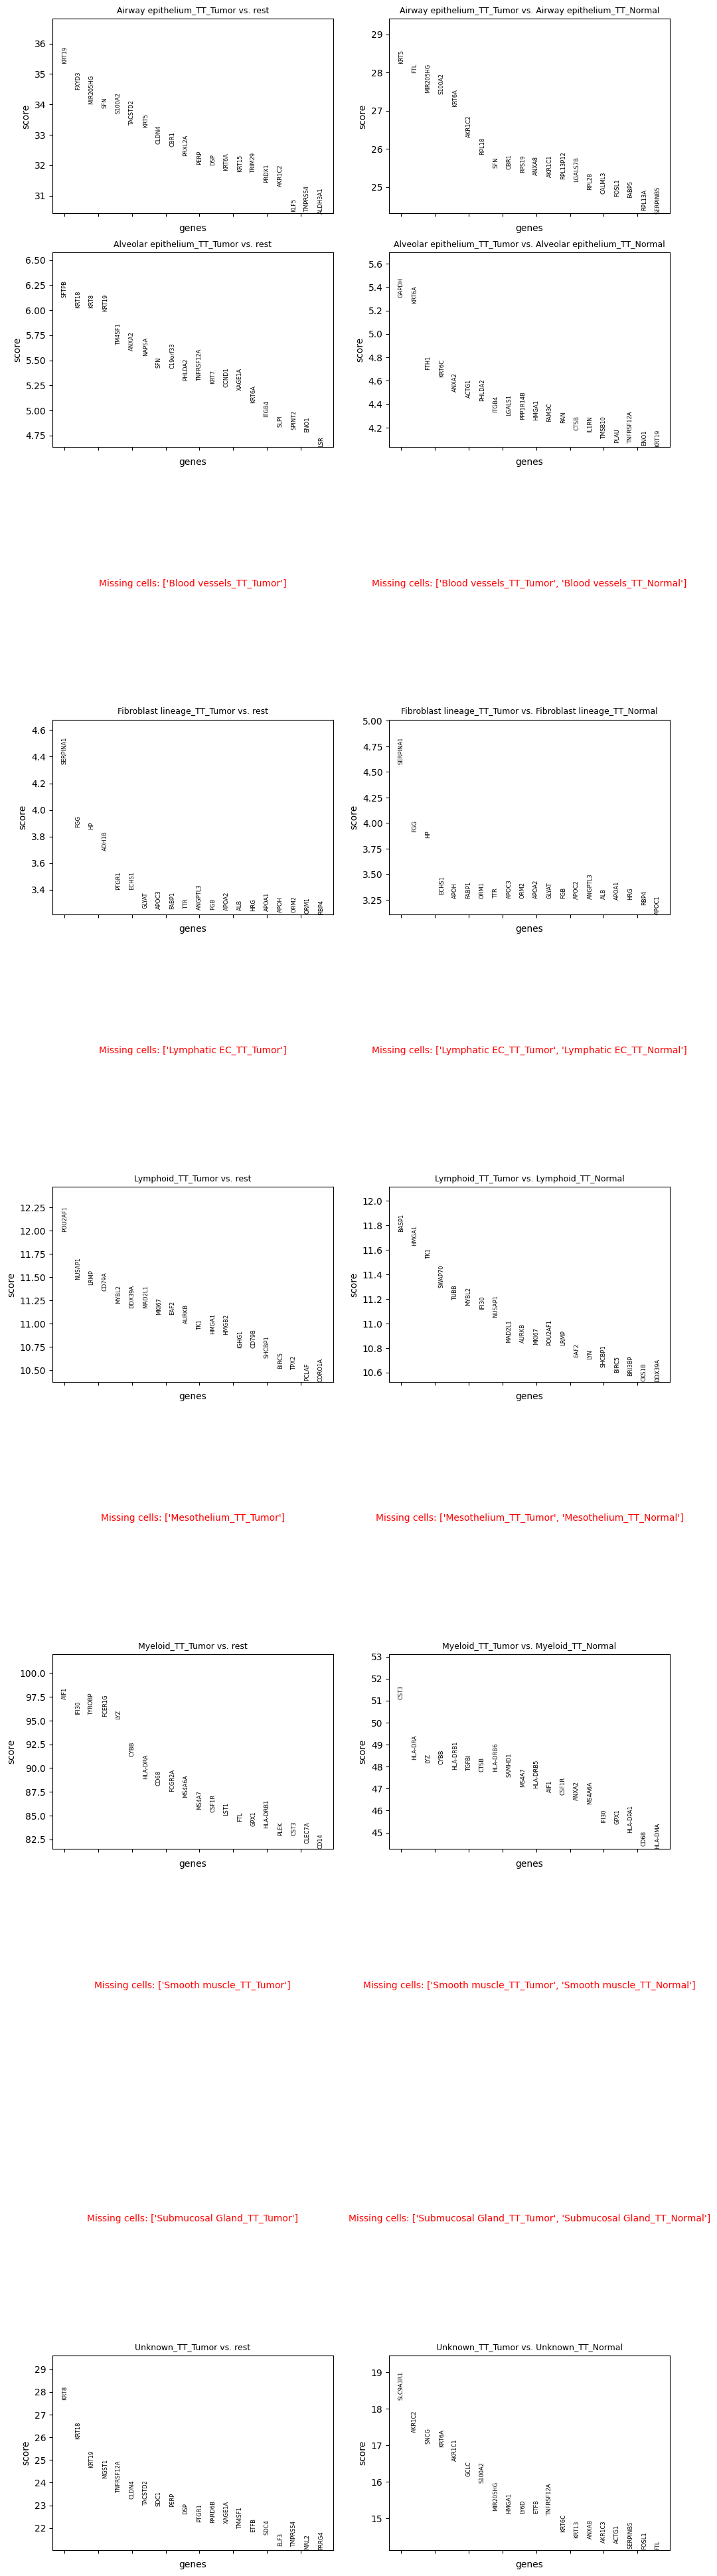

In [22]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [23]:
adata.obs.origin.str.contains('normal').any()

False

In [24]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

/tmp/ipykernel_142893/3062282855.py:27: UserWarning: No healthy tissue!
  warn('No healthy tissue!')


## Heatmaps

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, Alveolar epithelium_TT_Normal, etc.
var_group_labels: Lymphoid_TT_Normal, Myeloid_TT_Tumor, Fibroblast lineage_TT_Normal, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


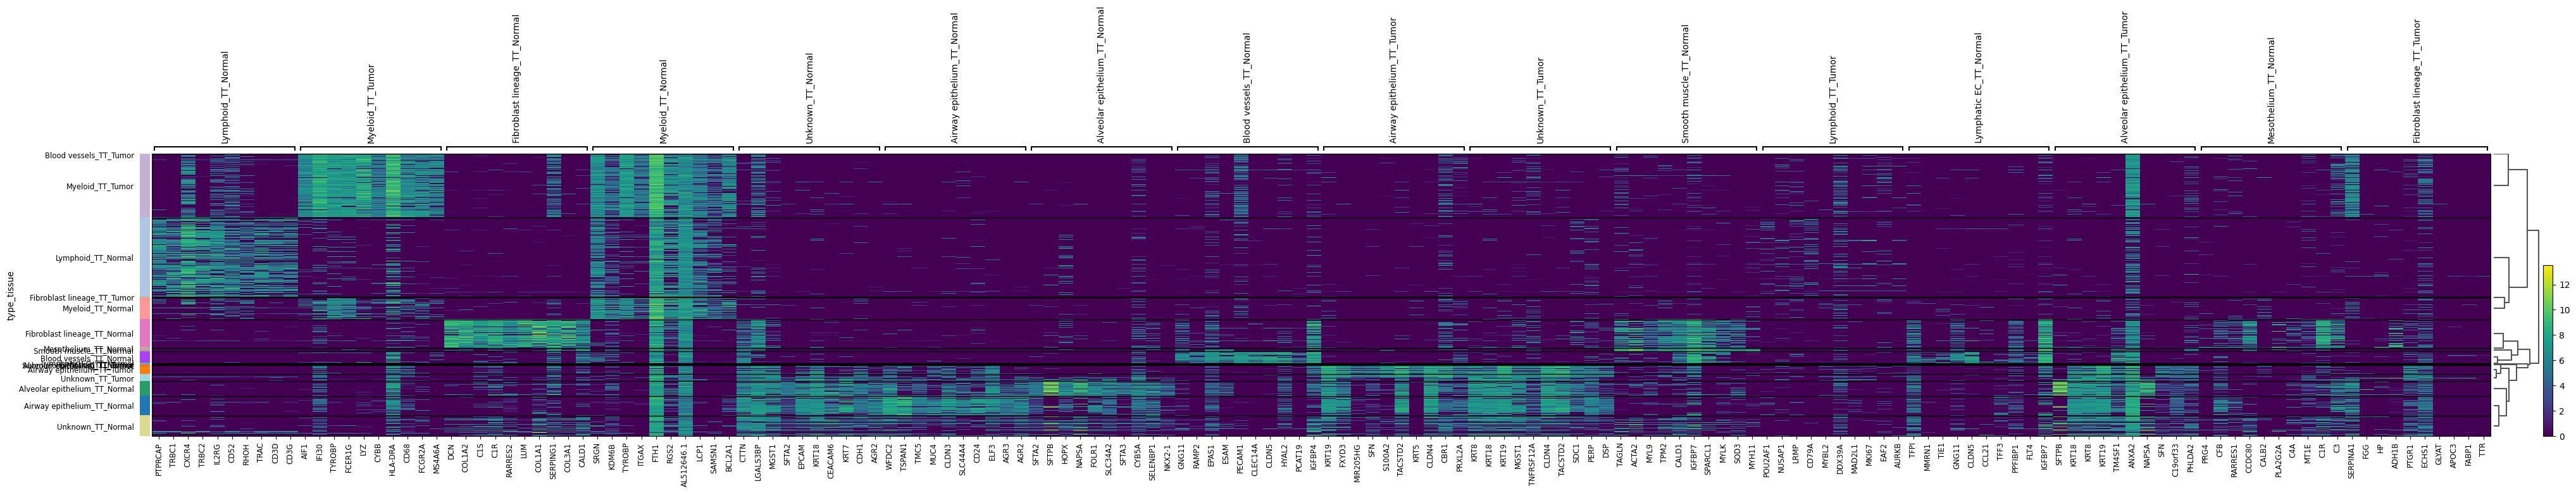

In [25]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [26]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [27]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [28]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [29]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [30]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str], types: List[str], id_: str, load_gsea: bool = False) -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)

    gsea_folder = 'gseapy_gsea'
    dfs = []

    for type in types:
        wilco = adata.uns['wilcoxon']
        gsea_path = f'{gsea_folder}/{type}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [31]:
types = adata.obs.loc[lambda x: x['final_pred']== 'Tumor' ]['type_tissue'].unique()

combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea=False)

/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:21,226 [WARNING] Duplicated values found in preranked stats: 27.87% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:22,717 [WARNING] Duplicated values found in preranked stats: 56.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:24,328 [WARNING] Duplicated values found in preranked stats: 80.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:25,867 [WARNING] Duplicated values found in preranked stats: 67.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:27,256 [WARNING] Duplicated values found in preranked stats: 38.91% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:28,889 [WARNING] Duplicated values found in preranked stats: 40.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


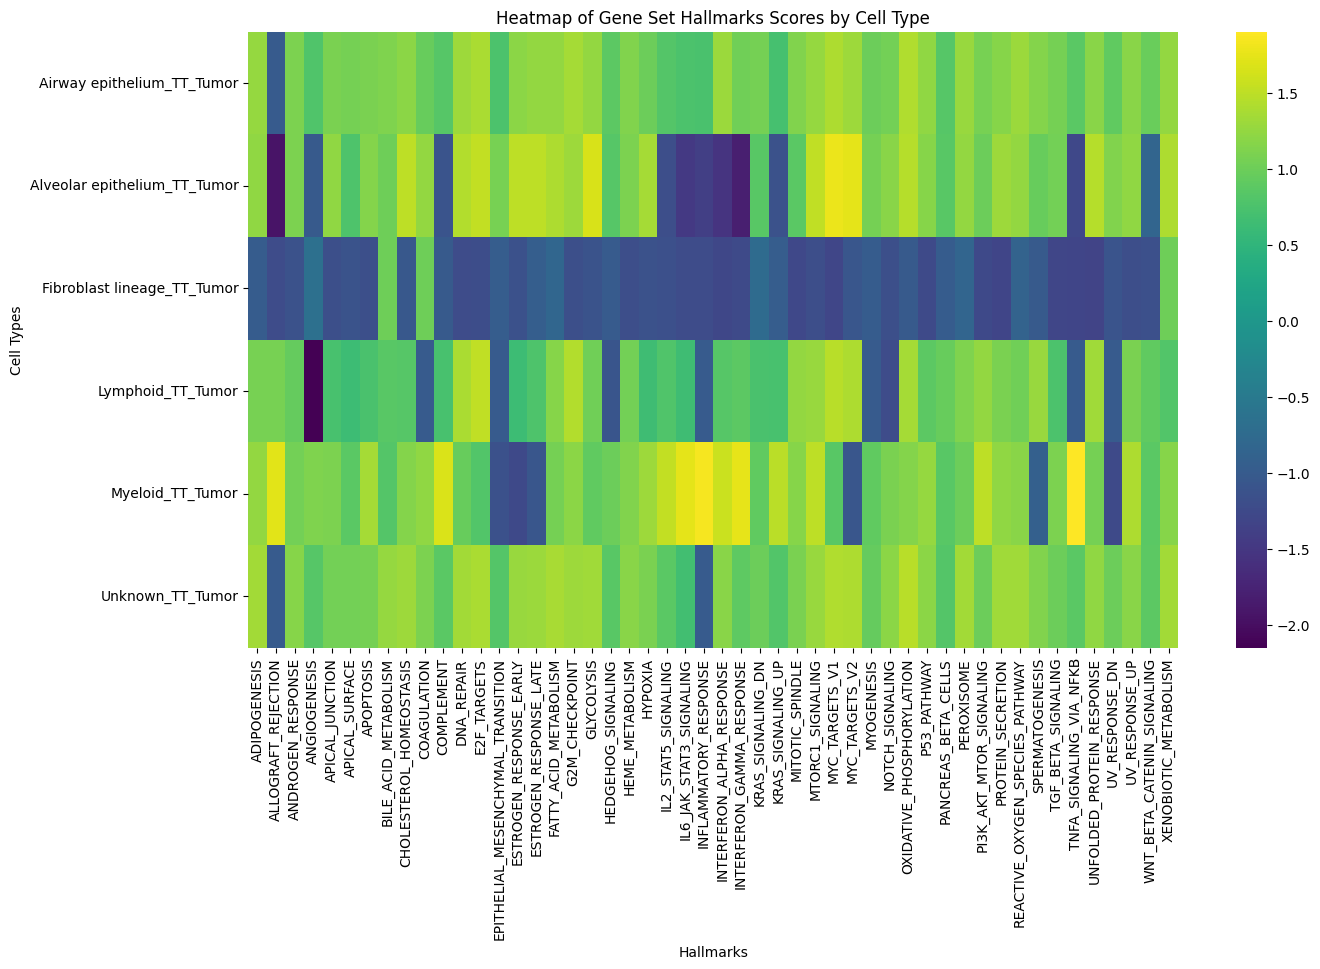

In [32]:
# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

In [33]:
types = adata.obs.loc[lambda x: x['final_pred']== 'Normal' ]['type_tissue'].unique()

combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea)

/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:31,461 [WARNING] Duplicated values found in preranked stats: 37.85% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:33,048 [WARNING] Duplicated values found in preranked stats: 25.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:34,568 [WARNING] Duplicated values found in preranked stats: 32.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:36,302 [WARNING] Duplicated values found in preranked stats: 28.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:38,078 [WARNING] Duplicated values found in preranked stats: 51.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:39,719 [WARNING] Duplicated values found in preranked stats: 31.41% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:41,433 [WARNING] Duplicated values found in preranked stats: 30.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:42,913 [WARNING] Duplicated values found in preranked stats: 67.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:44,445 [WARNING] Duplicated values found in preranked stats: 35.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_142893/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-01-26 19:21:46,116 [WARNING] Duplicated values found in preranked stats: 61.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


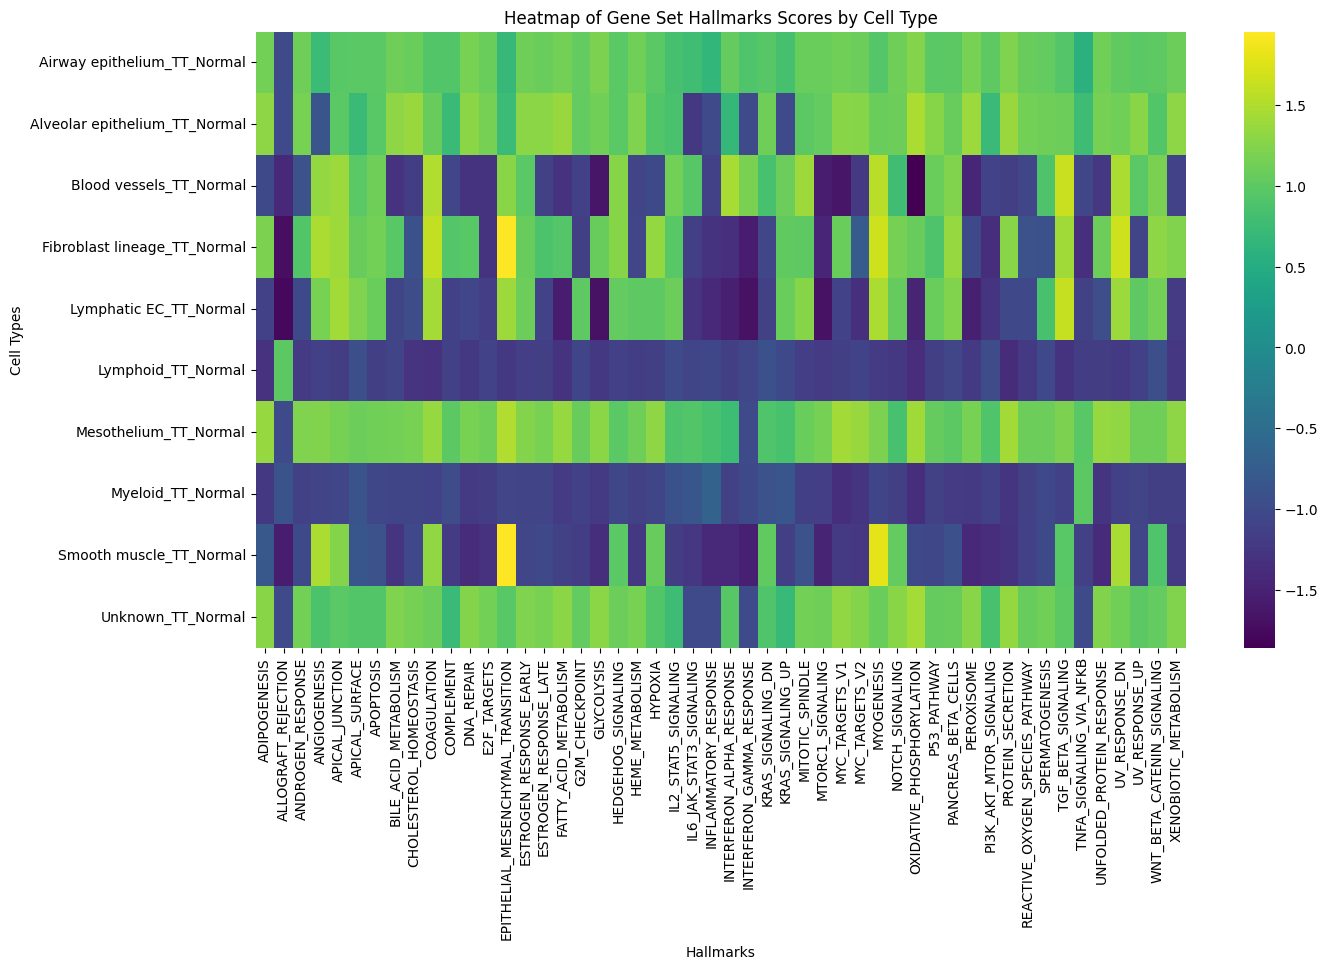

In [34]:
# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()